# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:51<00:00, 1690.25it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
preprocessed_summary = []
# tqdm is for printing the status bar
try:
    for sentance in final['Summary'].values:
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_summary.append(sentance.strip())
except:
    pass

C:\Users\rites\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\rites\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\rites\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\rites\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 116756)
the number of unique words  116756


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 203034)
the number of unique words including both unigrams and bigrams  203034


## [4.4] Word2Vec

In [77]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8547688722610474), ('awesome', 0.8541616201400757), ('terrific', 0.8541508913040161), ('fantastic', 0.8533832430839539), ('excellent', 0.814172089099884), ('perfect', 0.7747476696968079), ('wonderful', 0.7739632725715637), ('nice', 0.7252894043922424), ('fabulous', 0.7226467132568359), ('amazing', 0.7218233346939087)]
[('greatest', 0.7951465845108032), ('nastiest', 0.7538052797317505), ('best', 0.6990302801132202), ('tastiest', 0.6707860827445984), ('disgusting', 0.6687446236610413), ('terrible', 0.6624380946159363), ('horrible', 0.6498257517814636), ('awful', 0.6402725577354431), ('horrid', 0.6175782680511475), ('vile', 0.6158354878425598)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  23202
sample words  ['bulgur', 'negate', 'top', 'xxx', 'satiety', 'vera', 'suppressant', 'gripes', 'harming', 'pilon', 'artichoke', 'holic', 'weight', 'adoption', 'mislead', 'freezers', 'rodent', 'simular', 'granule', 'colleagues', 'quenched', 'offices', 'entrees', 'mention', 'god', 'message', 'clarify', 'join', 'dyeing', 'gumbo', 'develops', 'sojo', 'heartily', 'sonic', 'patent', 'zone', 'evian', 'idol', 'path', 'pete', 'fiona', 'peers', 'pictured', 'sell', 'darkish', 'spectacular', 'ped', 'sprinkled', 'eucalyptus', 'digestives']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [31]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


In [25]:
# Function to plot confusion matrix
def confusion_matrix_plot(test_y, predict_y):
    # C stores the confusion matrix 
    C = confusion_matrix(test_y, predict_y)
    
    
    # Class labels 
    labels_x = ["Predicted No","Predicted Yes"]
    labels_y = ["Original No","Original Yes"]
    
    cmap=sns.light_palette("orange")
    plt.figure(figsize=(4,4))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.title("Confusion Matrix")
    plt.show()

In [26]:
# Function to plot roc curve

def plot_roc_curve(Y_test,predict_y_test,Y_train,predict_y_train):
    plt.figure(figsize=(10,5))
    fpr1,tpr1,threshold1 = roc_curve(Y_test,predict_y_test) # For test dataset
    fpr2,tpr2,threshold2 = roc_curve(Y_train,predict_y_train) # For train dataset
    
    plt.plot([0,1],[0,1])
    plt.plot(fpr1,tpr1,label="Test AUC")
    plt.plot(fpr2,tpr2,label="Train AUC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc = 'lower right')
    plt.title("Reciever Operating Characteristic")
    plt.grid()
    plt.show()

In [53]:
def plot_train_auc_heatmap(C):
    labels_y =['5','10','50','100','200','500','1000']
    labels_x= ['2','3','4','5','6','7','8','9','10']
    
    cmap=sns.light_palette("orange")
    #print("AUC on train dataset")
    plt.figure(figsize=(11,8))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.xlabel("Max Depth")
    plt.ylabel("n_estimators")
    plt.title("AUC on train dataset")
    plt.show()
    

In [54]:
def plot_test_auc_heatmap(C):
    labels_y =['5','10','50','100','200','500','1000']
    labels_x= ['2','3','4','5','6','7','8','9','10']
    
    cmap=sns.light_palette("orange")
    #print("AUC on train dataset")
    plt.figure(figsize=(11,8))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.xlabel("Max Depth")
    plt.ylabel("n_estimators")
    plt.title("AUC on CV dataset")
    plt.show()
    

In [30]:
def xg_plot_train_auc_heatmap(C):
    labels_y =['5','10','50','100','200','500','1000']
    labels_x= ['2','3','4','5','6','7','8','9','10']
    
    cmap=sns.light_palette("orange")
    #print("AUC on train dataset")
    plt.figure(figsize=(10,8))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.xlabel("Max Depth")
    plt.ylabel("n_estimators")
    plt.title("AUC on train dataset")
    plt.show()

In [31]:
def xg_plot_test_auc_heatmap(C):
    labels_y =['5','10','50','100','200','500','1000']
    labels_x= ['2','3','4','5','6','7','8','9','10']
    
    cmap=sns.light_palette("orange")
    #print("AUC on train dataset")
    plt.figure(figsize=(10,8))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.xlabel("Max Depth")
    plt.ylabel("n_estimators")
    plt.title("AUC on CV dataset")
    plt.show()

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [33]:
# initializing count vectorizer
count_vect = CountVectorizer()

# Splitting data into train and test dataset
from sklearn.model_selection import train_test_split
X = preprocessed_reviews # Getting datapoints
Y = final['Score'] # Geting labeels 

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train))
print(len(X_test))

61441
26332


In [34]:
# Vectorizing train and test dataset
bow_train_vect = count_vect.fit_transform(X_train)
bow_test_vect = count_vect.transform(X_test)

In [55]:
n_estimators = [5,10,50,100,200,500,1000]
max_depth = [2,3,4,5,6,7,8,9,10]

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        clf.fit(bow_train_vect,Y_train)
        
        predict_probab = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.
    

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [07:03<00:00, 97.31s/it]


Training AUC


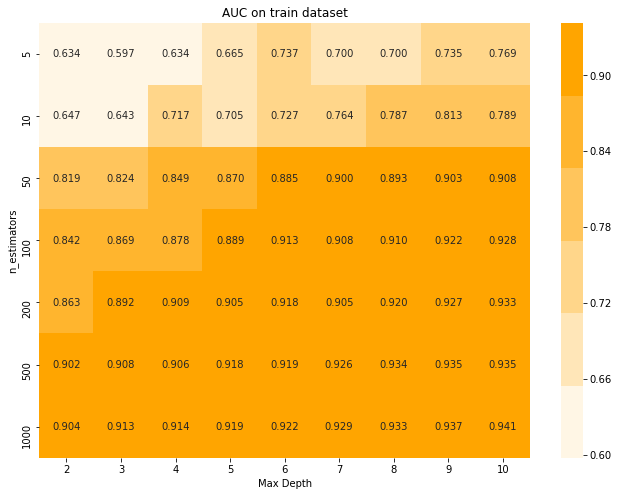

In [57]:
# Plotting plot of AUC for each combination of hyper parameters
print("Training AUC")
plot_train_auc_heatmap(train_auc)

In [58]:
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # Deecision Tree Classifier
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(bow_train_vect):
            x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [38:42<00:00, 540.03s/it]


Cross-validation AUC


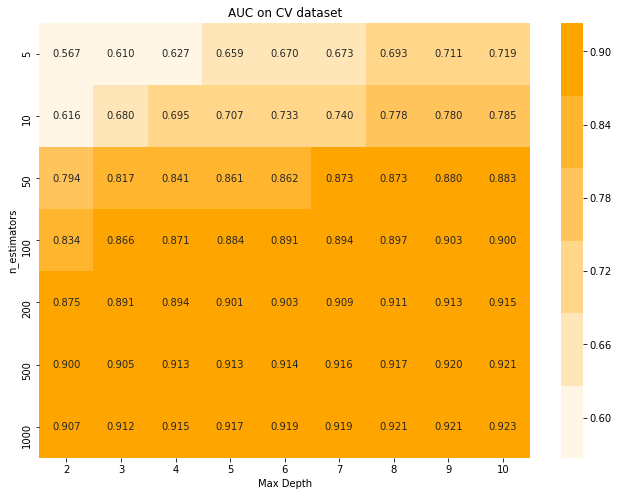

In [59]:
# Plotting plot of AUC for each combination of hyper parameters
print("Cross-validation AUC")
plot_test_auc_heatmap(cv_auc)

In [60]:
# Training the final model on best hyper-parameters
clf = RandomForestClassifier(n_estimators=1000,max_depth=10,n_jobs=-1,class_weight='balanced')
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)
predict_y_train = clf.predict(bow_train_vect)

probab_y_test = clf.predict_proba(bow_test_vect)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Bow Vectorized Model is {:.3f}".format(auc))

Auc of Bow Vectorized Model is 0.927


For test dataset


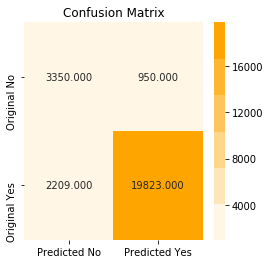

In [61]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


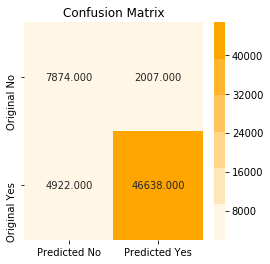

In [62]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

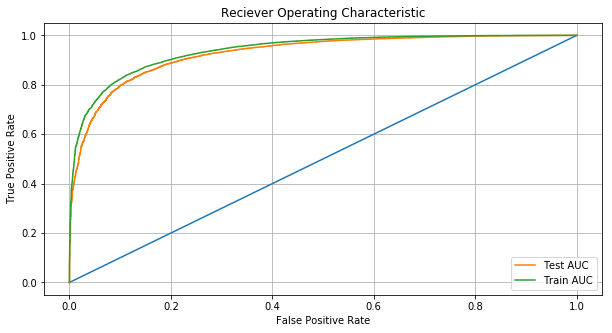

In [63]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

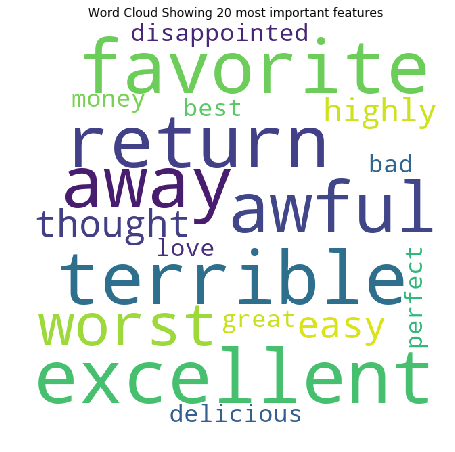

In [64]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

stopwords = set(STOPWORDS)

# Getting all the feature names
all_feat = count_vect.get_feature_names()
# Getting index of top 20 features.
top_20_feat_index = clf.feature_importances_.argsort()[-20:]

top_20_feat = [all_feat[i] for i in top_20_feat_index]

feat_str = ' '
for wrd in top_20_feat:
    feat_str = feat_str + wrd + ' '



wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 6).generate(feat_str)

# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud Showing 20 most important features")
  
plt.show() 

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [47]:
# Initializing Tfidf Vectorizer
tfidf_vect = TfidfVectorizer()

# Vectorizing train and test dataset
tfidf_train_vect = tfidf_vect.fit_transform(X_train)
tfidf_test_vect = tfidf_vect.transform(X_test)

In [65]:
# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        clf.fit(tfidf_train_vect,Y_train)
        
        predict_probab = clf.predict_proba(tfidf_train_vect)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.
    

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [07:17<00:00, 102.62s/it]


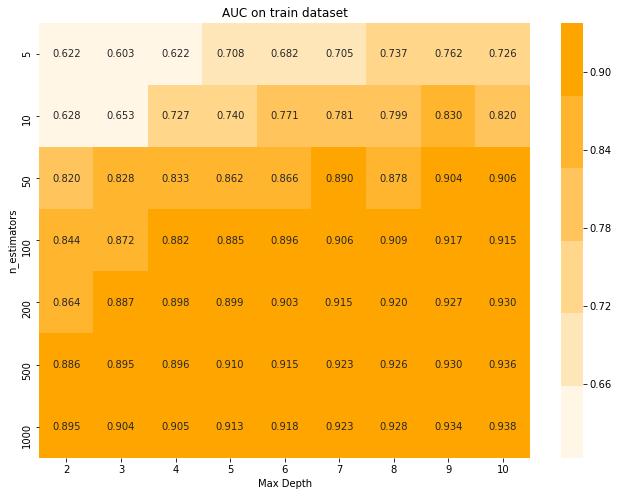

In [66]:
# Plotting plot of AUC for each combination of hyper parameters
plot_train_auc_heatmap(train_auc)

In [67]:
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # Deecision Tree Classifier
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(tfidf_train_vect):
            x_train = tfidf_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = tfidf_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [38:38<00:00, 546.43s/it]


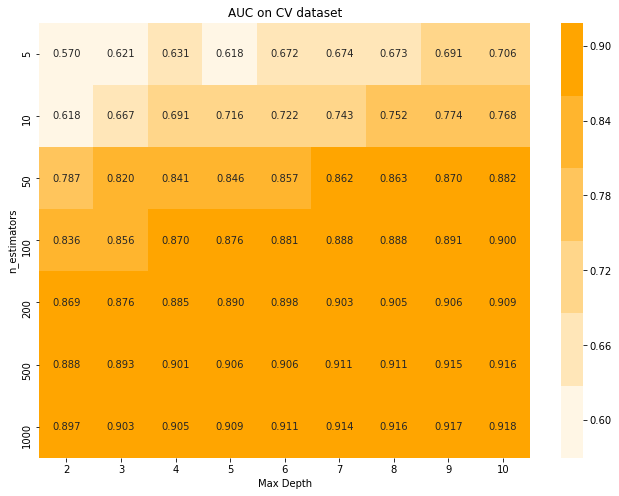

In [68]:
# Plotting plot of AUC for each combination of hyper parameters
plot_test_auc_heatmap(cv_auc)

In [70]:
# Training the final model on best hyper-parameters
clf = RandomForestClassifier(n_estimators=1000,max_depth=10,n_jobs=-1,class_weight='balanced')
clf.fit(tfidf_train_vect,Y_train)

predict_y_test = clf.predict(tfidf_test_vect)
predict_y_train = clf.predict(tfidf_train_vect)

probab_y_test = clf.predict_proba(tfidf_test_vect)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(tfidf_train_vect)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Tfidf Vectorized Model is {:.3f}".format(auc))

Auc of Tfidf Vectorized Model is 0.918


For test dataset


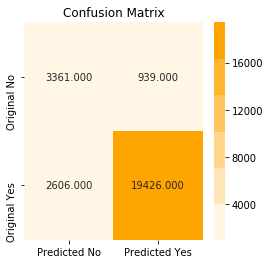

In [71]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


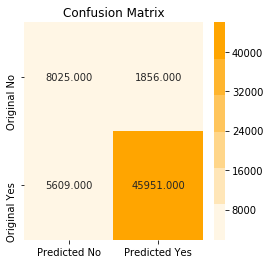

In [73]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

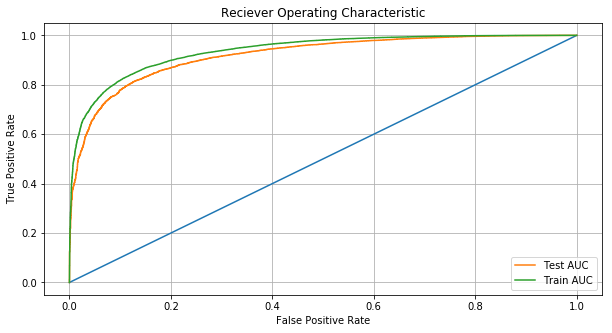

In [74]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

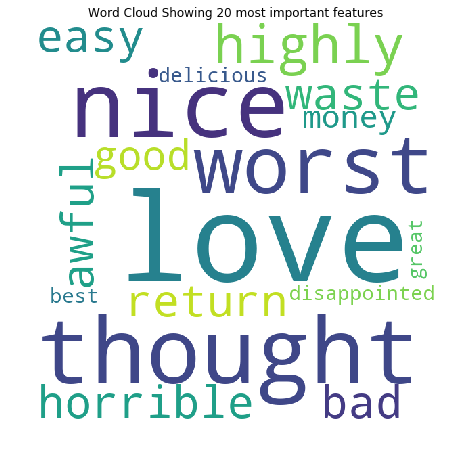

In [75]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

stopwords = set(STOPWORDS)

# Getting all the feature names
all_feat = tfidf_vect.get_feature_names()
# Getting index of top 20 features.
top_20_feat_index = clf.feature_importances_.argsort()[-20:]

top_20_feat = [all_feat[i] for i in top_20_feat_index]

feat_str = ' '
for wrd in top_20_feat:
    feat_str = feat_str + wrd + ' '



wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 6).generate(feat_str)

# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud Showing 20 most important features")
  
plt.show() 

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [78]:
# Splitting data into train and test dataset

X = list_of_sentance

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

In [79]:
# Train Word2vec model on train dataset and use this for test dataset vectorization
# Training word2Vec model on traain dataset and will use same for test dataset
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(X_train,min_count=5,size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.7750309705734253), ('awesome', 0.774991512298584), ('good', 0.7535659074783325), ('excellent', 0.7473593950271606), ('wonderful', 0.7224867343902588), ('terrific', 0.7164211273193359), ('amazing', 0.6778523921966553), ('fabulous', 0.6135283708572388), ('nice', 0.6029989123344421), ('perfect', 0.6015686988830566)]
[('greatest', 0.7874018549919128), ('best', 0.7049573063850403), ('tastiest', 0.6305773854255676), ('smoothest', 0.6266797780990601), ('closest', 0.6235805749893188), ('nicest', 0.6005889177322388), ('disgusting', 0.5863691568374634), ('awful', 0.5767752528190613), ('horrible', 0.5763019323348999), ('terrible', 0.5747752785682678)]


In [80]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14819
sample words  ['use', 'beans', 'espresso', 'machine', 'love', 'taste', 'straight', 'coffee', 'find', 'much', 'caffeine', 'tastes', 'great', 'subscribe', 'amazon', 'receive', 'order', 'month', 'discount', 'free', 'shipping', 'good', 'deal', 'normally', 'drink', 'starbucks', 'brand', 'bottled', 'comparison', 'based', 'illy', 'not', 'sweet', 'drawback', 'found', 'strength', 'perfect', 'flavor', 'pretty', 'well', 'little', 'bit', 'sweeter', 'would', 'like', 'dessert', 'really', 'trying', 'loose', 'baby']


In [81]:
# average Word2Vec
# compute average word2vec for each review of training dataset

train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [10:24<00:00, 98.37it/s]


61441
100


In [82]:
test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [04:29<00:00, 97.87it/s]


26332
100


In [83]:
# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        clf.fit(train_sent_vectors,Y_train)
        
        predict_probab = clf.predict_proba(train_sent_vectors)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.
    

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [59:26<00:00, 833.04s/it]


Training AUC


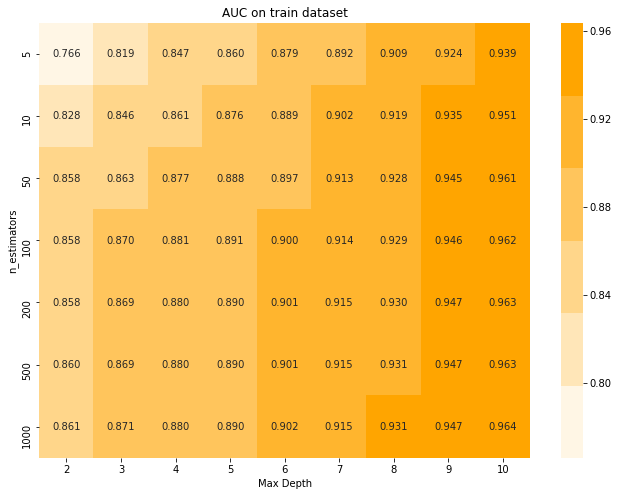

In [84]:
# Plotting plot of AUC for each combination of hyper parameters
print("Training AUC")
plot_train_auc_heatmap(train_auc)

In [85]:
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # Deecision Tree Classifier
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(train_sent_vectors):
            x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [1:49:18<00:00, 1581.07s/it]


Cross-Validation AUC


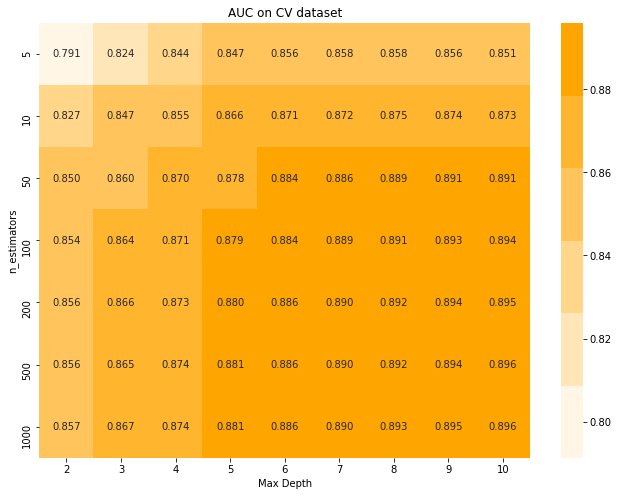

In [86]:
# Plotting plot of AUC for each combination of hyper parameters
print("Cross-Validation AUC")
plot_test_auc_heatmap(cv_auc)

In [87]:
# Training the final model on best hyper-parameters
clf = RandomForestClassifier(n_estimators=1000,max_depth=10,n_jobs=-1,class_weight='balanced')
clf.fit(train_sent_vectors,Y_train)

predict_y_test = clf.predict(test_sent_vectors)
predict_y_train = clf.predict(train_sent_vectors)

probab_y_test = clf.predict_proba(test_sent_vectors)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(train_sent_vectors)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Bow Vectorized Model is {:.3f}".format(auc))

Auc of Bow Vectorized Model is 0.903


For test dataset


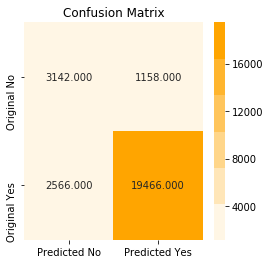

In [88]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


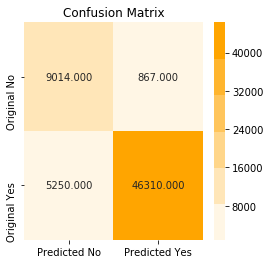

In [90]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

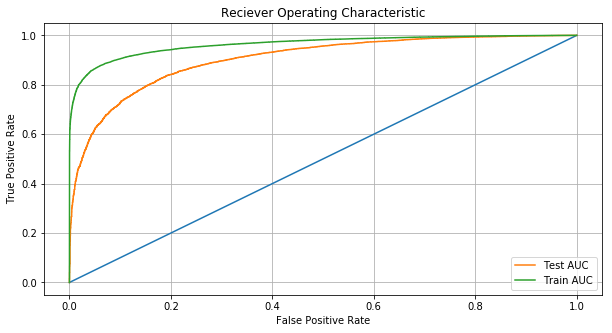

In [91]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [92]:
# X_train contains sentences for training and X_test contains sentances for testing the model.
# Calculating TfidfW2V for X_train
from sklearn.model_selection import train_test_split
Y = final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,Y,test_size=0.3,random_state=42)

model = TfidfVectorizer()
train_tfidf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [93]:
# Training word2Vec model on traain dataset and will use same for test dataset
w2v_train = []
for sent in X_train:
    w2v_train.append(sent.split())

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(w2v_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8300073146820068), ('fantastic', 0.8280240297317505), ('good', 0.8219002485275269), ('terrific', 0.7934580445289612), ('excellent', 0.791223406791687), ('wonderful', 0.7643818259239197), ('amazing', 0.7524603009223938), ('fabulous', 0.7318288087844849), ('perfect', 0.7306274175643921), ('decent', 0.6918848752975464)]
[('greatest', 0.8129244446754456), ('best', 0.7069724202156067), ('experienced', 0.7017791867256165), ('tastiest', 0.6758334636688232), ('smoothest', 0.6342449188232422), ('closest', 0.6328778266906738), ('terrible', 0.6201767921447754), ('horrible', 0.6135932803153992), ('foul', 0.6039876937866211), ('awful', 0.5898479223251343)]


In [94]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14819
sample words  ['use', 'beans', 'espresso', 'machine', 'love', 'taste', 'straight', 'coffee', 'find', 'much', 'caffeine', 'tastes', 'great', 'subscribe', 'amazon', 'receive', 'order', 'month', 'discount', 'free', 'shipping', 'good', 'deal', 'normally', 'drink', 'starbucks', 'brand', 'bottled', 'comparison', 'based', 'illy', 'not', 'sweet', 'drawback', 'found', 'strength', 'perfect', 'flavor', 'pretty', 'well', 'little', 'bit', 'sweeter', 'would', 'like', 'dessert', 'really', 'trying', 'loose', 'baby']


In [95]:
list_of_sentence=[]
for sent in preprocessed_reviews:
    list_of_sentence.append(sent.split())

In [96]:
X_train,X_test,Y_train,Y_test = train_test_split(list_of_sentence,Y,test_size=0.3,random_state=42)

In [97]:
# TF-IDF weighted Word2Vec for X_train
train_tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review of X_train is stored in this list
row=0;
for sent in tqdm(X_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in train_tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [42:50<00:00, 15.12it/s]


In [98]:
# TF-IDF weighted Word2Vec for X_test
test_tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review of X_train is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in test_tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [17:37<00:00, 24.91it/s]


In [99]:
# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        clf.fit(train_tfidf_sent_vectors,Y_train)
        
        predict_probab = clf.predict_proba(train_tfidf_sent_vectors)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.
    

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [34:06<00:00, 490.34s/it]


Training AUC


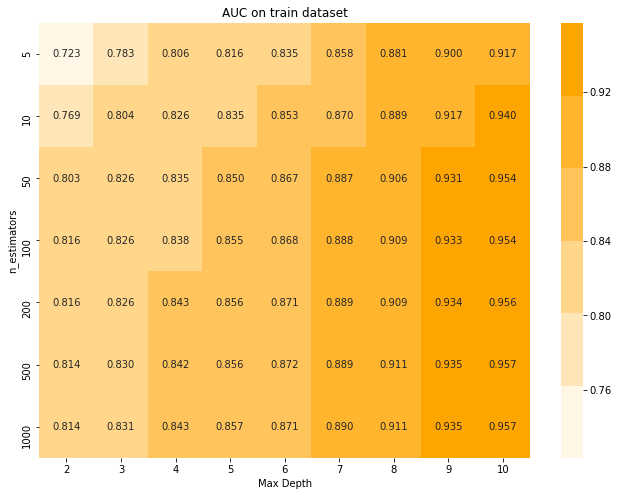

In [100]:
# Plotting plot of AUC for each combination of hyper parameters
print("Training AUC")
plot_train_auc_heatmap(train_auc)

In [101]:
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# In this section we will perform 3-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # Deecision Tree Classifier
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(train_tfidf_sent_vectors):
            x_train = train_tfidf_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = train_tfidf_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [46:41<00:00, 668.63s/it]


Cross-Validation AUC


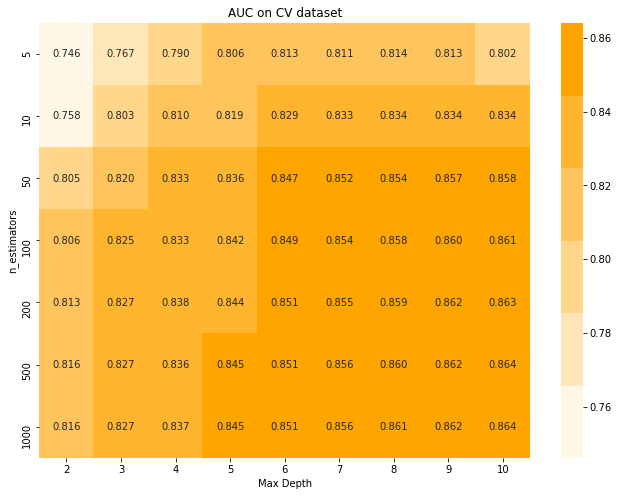

In [102]:
# Plotting plot of AUC for each combination of hyper parameters
print("Cross-Validation AUC")
plot_test_auc_heatmap(cv_auc)

In [103]:
# Training the final model on best hyper-parameters
clf = RandomForestClassifier(n_estimators=1000,max_depth=10,n_jobs=-1,class_weight='balanced')
clf.fit(train_tfidf_sent_vectors,Y_train)

predict_y_test = clf.predict(test_tfidf_sent_vectors)
predict_y_train = clf.predict(train_tfidf_sent_vectors)

probab_y_test = clf.predict_proba(test_tfidf_sent_vectors)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(train_tfidf_sent_vectors)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Bow Vectorized Model is {:.3f}".format(auc))

Auc of Bow Vectorized Model is 0.874


For test dataset


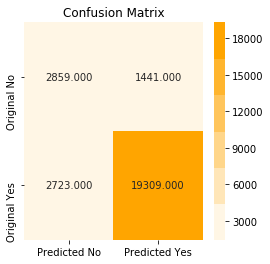

In [104]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


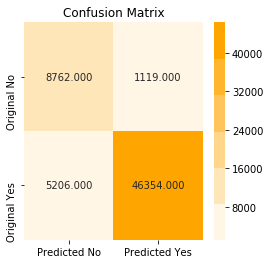

In [105]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

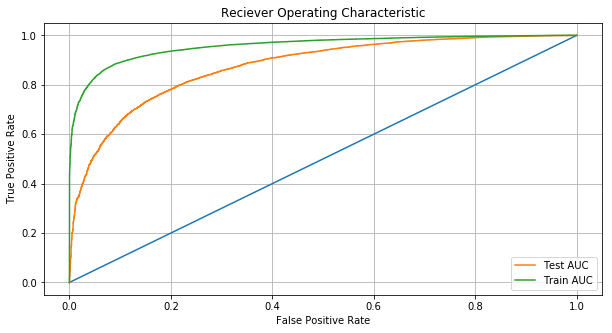

In [106]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [37]:
n_estimators = [5,10,50,100,200,500,1000]
max_depth = [2,3,4,5,6,7,8,9,10]

In [38]:
from xgboost import XGBClassifier

# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf=XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1)
        clf.fit(bow_train_vect,Y_train)
        
        predict_probab = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.
    


100%|██████████| 7/7 [22:32<00:00, 314.95s/it]


Training AUC


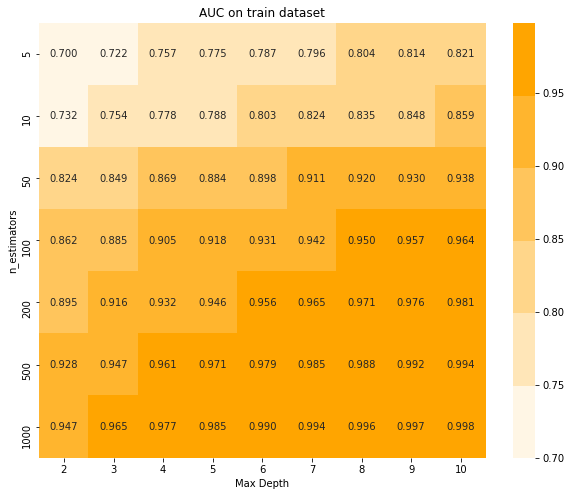

In [39]:
# Plotting plot of AUC for each combination of hyper parameters
print("Training AUC")
xg_plot_train_auc_heatmap(train_auc)

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # XGB Classifier
        clf=XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1)
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(bow_train_vect):
            x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
100%|██████████| 7/7 [49:03<00:00, 692.41s/it]


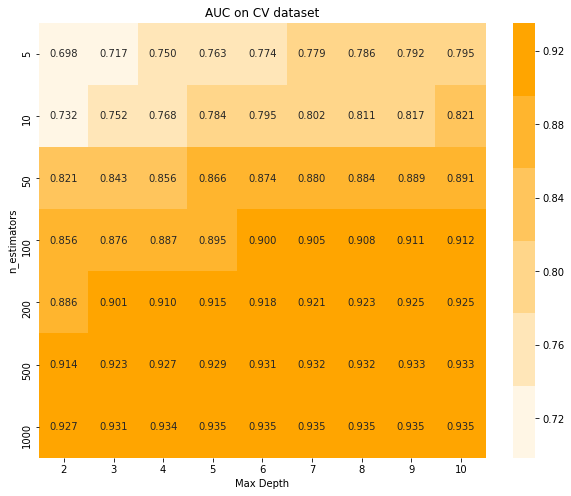

In [50]:
# Plotting plot of AUC for each combination of hyper parameters
xg_plot_test_auc_heatmap(cv_auc)

In [42]:
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [43]:
# Training the final model on best hyper-parameters
clf = XGBClassifier(n_estimators=1000,max_depth=5,n_jobs=-1)
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)
predict_y_train = clf.predict(bow_train_vect)

probab_y_test = clf.predict_proba(bow_test_vect)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Bow Vectorized Model is {:.3f}".format(auc))

Auc of Bow Vectorized Model is 0.943


For test dataset


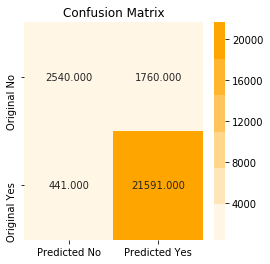

In [44]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


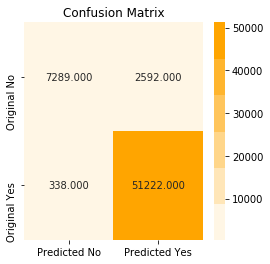

In [45]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

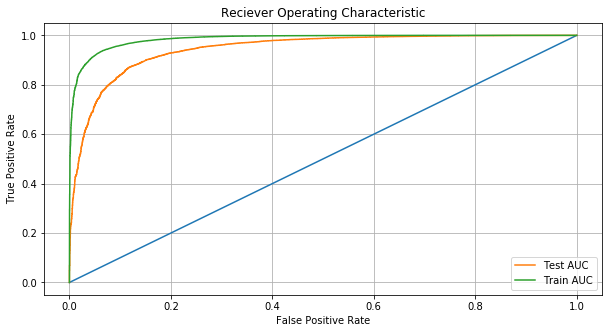

In [46]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [47]:
# Initializing Tfidf Vectorizer
tfidf_vect = TfidfVectorizer()

# Vectorizing train and test dataset
tfidf_train_vect = tfidf_vect.fit_transform(X_train)
tfidf_test_vect = tfidf_vect.transform(X_test)

In [48]:
from xgboost import XGBClassifier

# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf=XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1)
        clf.fit(tfidf_train_vect,Y_train)
        
        predict_probab = clf.predict_proba(tfidf_train_vect)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.
    

100%|██████████| 7/7 [40:21<00:00, 569.93s/it]


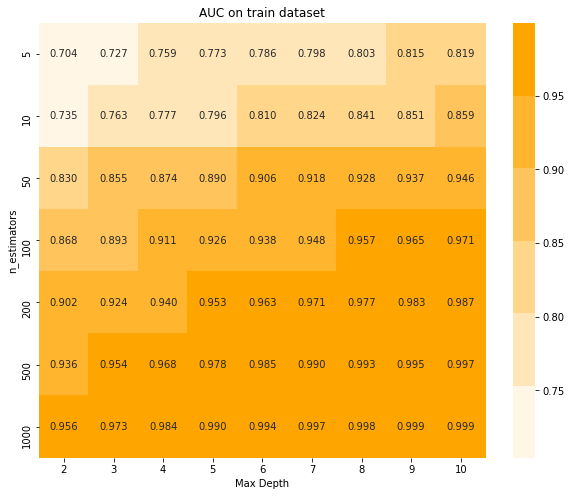

In [51]:
# Plotting plot of AUC for each combination of hyper parameters
xg_plot_train_auc_heatmap(train_auc)

In [52]:

from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # XGB Classifier
        clf=XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1)
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(tfidf_train_vect):
            x_train = tfidf_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = tfidf_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|██████████| 7/7 [2:04:35<00:00, 1770.48s/it]


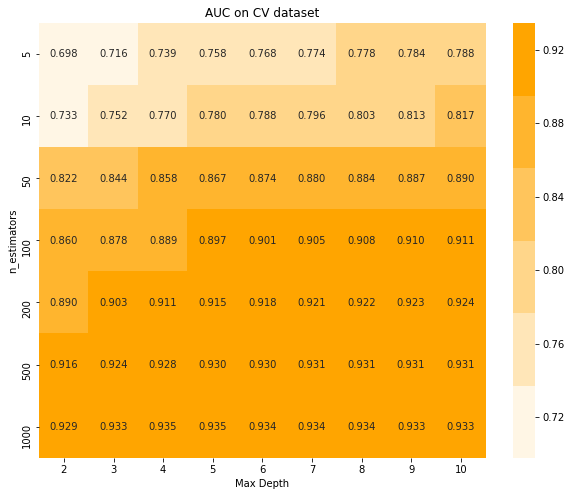

In [53]:
# Plotting plot of AUC for each combination of hyper parameters
xg_plot_test_auc_heatmap(cv_auc)

In [85]:
# Training the final model on best hyper-parameters
clf = XGBClassifier(n_estimators=1000,max_depth=4,n_jobs=-1)
clf.fit(tfidf_train_vect,Y_train)

predict_y_test = clf.predict(tfidf_test_vect)
predict_y_train = clf.predict(tfidf_train_vect)

probab_y_test = clf.predict_proba(tfidf_test_vect)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(tfidf_train_vect)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Tfidf Vectorized Model is {:.3f}".format(auc))

Auc of Tfidf Vectorized Model is 0.946


For test dataset


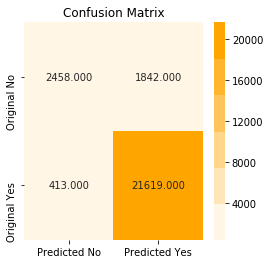

In [86]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


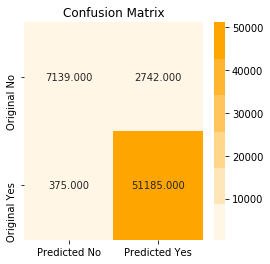

In [87]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

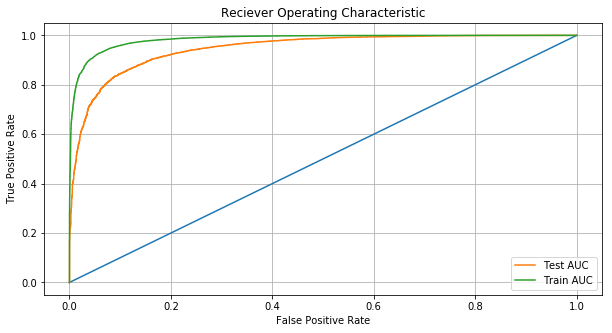

In [88]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [54]:
list_of_sentence=[]
for sent in preprocessed_reviews:
    list_of_sentence.append(sent.split())

In [55]:
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [56]:
# Splitting data into train and test dataset

X = list_of_sentence

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

In [57]:
# Train Word2vec model on train dataset and use this for test dataset vectorization
# Training word2Vec model on traain dataset and will use same for test dataset
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(X_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8390023708343506), ('awesome', 0.8284731507301331), ('fantastic', 0.8143223524093628), ('terrific', 0.8141315579414368), ('excellent', 0.7851373553276062), ('wonderful', 0.7746382355690002), ('perfect', 0.7495255470275879), ('amazing', 0.7411403059959412), ('fabulous', 0.7116612195968628), ('decent', 0.6748661398887634)]
[('greatest', 0.780515193939209), ('best', 0.7210771441459656), ('experienced', 0.6693117618560791), ('smoothest', 0.6225188970565796), ('closest', 0.6195427775382996), ('nastiest', 0.6175286173820496), ('tastiest', 0.6158047914505005), ('sweetest', 0.6142451167106628), ('awful', 0.61061692237854), ('terrible', 0.6048354506492615)]


In [58]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14819
sample words  ['flake', 'holding', 'carnivorous', 'soldier', 'anchor', 'overpowering', 'buddies', 'mainland', 'singing', 'wallpaper', 'shall', 'discernible', 'feel', 'town', 'oxygen', 'sauteeing', 'batali', 'tang', 'barrel', 'sprouters', 'wonka', 'engineering', 'compromise', 'broil', 'nido', 'disaster', 'shiniest', 'juicy', 'honesty', 'jewish', 'teenies', 'flatten', 'application', 'tendency', 'dropped', 'skinny', 'beautifully', 'worlds', 'os', 'doone', 'classify', 'clam', 'tek', 'circumstances', 'chunkier', 'physician', 'products', 'likes', 'pediatrician', 'jerquee']


In [59]:
# average Word2Vec
# compute average word2vec for each review of training dataset

train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

100%|██████████| 61441/61441 [12:40<00:00, 80.79it/s] 

61441
50


In [60]:
test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

100%|██████████| 26332/26332 [05:34<00:00, 78.75it/s] 

26332
50


In [61]:
# XgBoost dont take list as training data hence converting list of avg word2vec to pandas dataframe
import pandas as pd
# For train dataset
train_avg_w2v = pd.DataFrame(train_sent_vectors,columns=["f"+str(i) for i in range(1,51)])

# For test dataset
test_avg_w2v = pd.DataFrame(test_sent_vectors,columns=["f"+str(i) for i in range(1,51)])

In [62]:
train_avg_w2v.head(5)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50
0,-1.560417,-0.046639,0.248266,0.287027,-0.117397,0.306847,-1.493014,0.239451,0.876294,0.272031,...,0.127697,-0.276451,1.400507,1.291518,-1.085165,-0.880523,0.061699,-0.510285,0.281956,0.674110
1,-1.253325,-0.921579,0.271559,-0.149547,0.014046,0.160617,-0.370920,-0.310893,1.330967,0.096550,...,-0.359244,-0.862469,0.530903,0.036695,-0.619506,-0.825178,-0.165943,-0.498222,-0.213726,0.195696
2,-0.411293,0.356491,-0.037375,0.298867,1.031745,0.614958,-0.556390,-0.317174,0.275976,0.580415,...,0.361931,0.050541,0.474794,-0.317919,-0.076586,-0.473994,0.200595,0.157202,-0.043227,-0.621170
3,-0.241459,-0.041505,0.023508,0.100616,-0.176033,0.197557,-0.753765,-0.005021,0.388801,0.303358,...,-0.161035,0.293486,0.005340,1.607936,-0.023044,-0.115403,0.144392,-0.201287,-0.232914,0.036517
4,0.085517,0.140958,-1.544227,0.815313,1.148897,-1.185408,-0.027636,-0.318185,-0.601505,1.113308,...,-0.762762,-0.558068,0.602984,0.499654,0.471291,1.265684,0.047255,0.502940,0.566201,-0.341998


In [63]:
# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf=XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1)
        clf.fit(train_avg_w2v,Y_train)
        
        predict_probab = clf.predict_proba(train_avg_w2v)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.

100%|██████████| 7/7 [31:06<00:00, 445.14s/it]


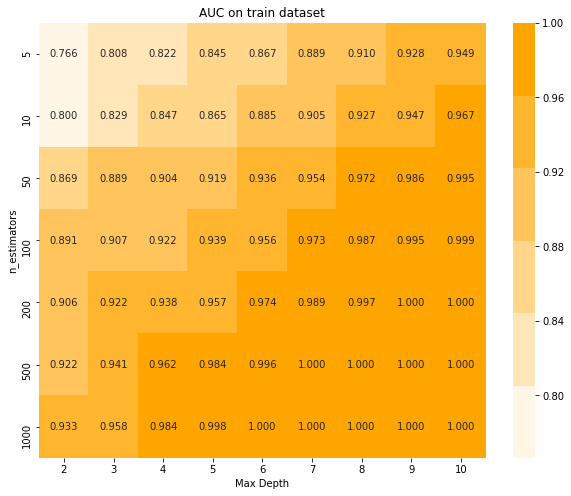

In [64]:
# Plotting plot of AUC for each combination of hyper parameters
xg_plot_train_auc_heatmap(train_auc)

In [65]:
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # Deecision Tree Classifier
        clf = XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1)
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(train_avg_w2v):
            x_train = train_avg_w2v[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = train_avg_w2v[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|██████████| 7/7 [1:14:38<00:00, 1064.99s/it]


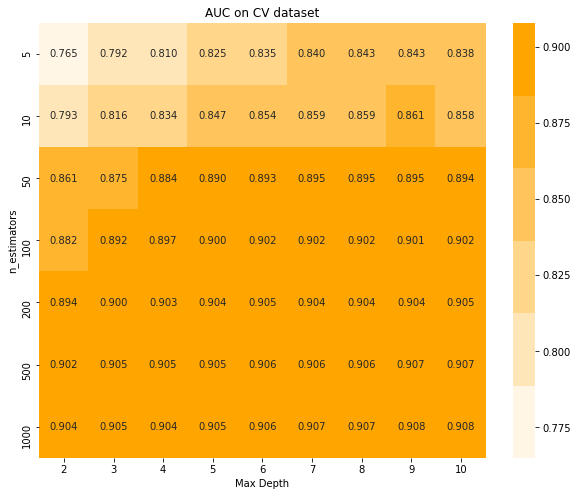

In [66]:
# Plotting plot of AUC for each combination of hyper parameters
xg_plot_test_auc_heatmap(cv_auc)

In [93]:
# Training the final model on best hyper-parameters
clf = XGBClassifier(n_estimators=1000,max_depth=3,n_jobs=-1)
clf.fit(train_avg_w2v,Y_train)

predict_y_test = clf.predict(test_avg_w2v)
predict_y_train = clf.predict(train_avg_w2v)

probab_y_test = clf.predict_proba(test_avg_w2v)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(train_avg_w2v)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Avg Word2Vec Vectorized Model is {:.3f}".format(auc))

Auc of Avg Word2Vec Vectorized Model is 0.913


For test dataset


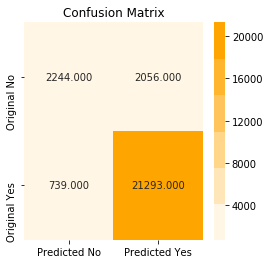

In [94]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


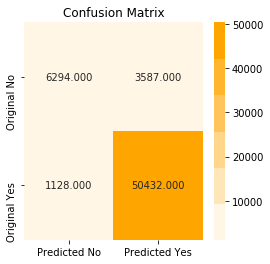

In [95]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

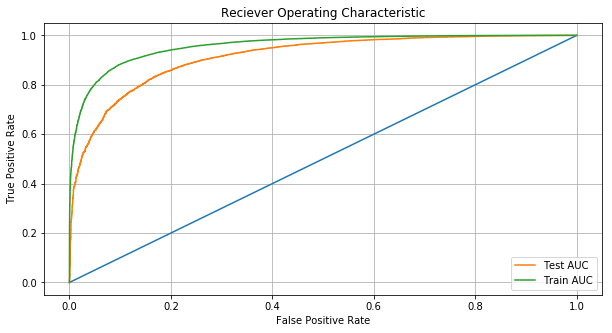

In [96]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [67]:
# X_train contains sentences for training and X_test contains sentances for testing the model.
# Calculating TfidfW2V for X_train
from sklearn.model_selection import train_test_split
Y = final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,Y,test_size=0.3,random_state=42)

model = TfidfVectorizer()
train_tfidf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [68]:
# Training word2Vec model on traain dataset and will use same for test dataset
w2v_train = []
for sent in X_train:
    w2v_train.append(sent.split())

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(w2v_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8521878719329834), ('fantastic', 0.8364487886428833), ('good', 0.833314061164856), ('excellent', 0.7966100573539734), ('amazing', 0.7827940583229065), ('wonderful', 0.7810209393501282), ('terrific', 0.7683424353599548), ('perfect', 0.7642394304275513), ('nice', 0.7050853967666626), ('decent', 0.70453941822052)]
[('greatest', 0.7815619707107544), ('best', 0.7260794043540955), ('tastiest', 0.6690521240234375), ('experienced', 0.6586390733718872), ('nastiest', 0.637919008731842), ('closest', 0.6219174861907959), ('disgusting', 0.6104392409324646), ('smoothest', 0.6082080006599426), ('terrible', 0.5952368974685669), ('awful', 0.5945000052452087)]


In [69]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14819
sample words  ['flake', 'holding', 'carnivorous', 'soldier', 'anchor', 'overpowering', 'buddies', 'mainland', 'singing', 'wallpaper', 'shall', 'discernible', 'feel', 'town', 'oxygen', 'sauteeing', 'batali', 'tang', 'barrel', 'sprouters', 'wonka', 'engineering', 'compromise', 'broil', 'nido', 'disaster', 'shiniest', 'juicy', 'honesty', 'jewish', 'teenies', 'flatten', 'application', 'tendency', 'dropped', 'skinny', 'beautifully', 'worlds', 'os', 'doone', 'classify', 'clam', 'tek', 'circumstances', 'chunkier', 'physician', 'products', 'likes', 'pediatrician', 'jerquee']


In [70]:
list_of_sentence=[]
for sent in preprocessed_reviews:
    list_of_sentence.append(sent.split())

In [71]:
X_train,X_test,Y_train,Y_test = train_test_split(list_of_sentence,Y,test_size=0.3,random_state=42)

In [72]:
# TF-IDF weighted Word2Vec for X_train
train_tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review of X_train is stored in this list
row=0;
for sent in tqdm(X_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in train_tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 61441/61441 [36:07<00:00, 28.35it/s]  


In [73]:
# TF-IDF weighted Word2Vec for X_test
test_tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review of X_train is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in test_tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [14:58<00:00, 29.31it/s]


In [74]:
# Getting number of features of each data point
print(len(train_tfidf_sent_vectors[0]))
print(len(test_tfidf_sent_vectors[0]))

50
50


In [75]:
# XgBoost dont take list as training data hence converting list of avg word2vec to pandas dataframe
import pandas as pd
# For train dataset
train_tfidf_avg_w2v = pd.DataFrame(train_tfidf_sent_vectors,columns=["f"+str(i) for i in range(1,51)])

# For test dataset
test_tfidf_avg_w2v = pd.DataFrame(test_tfidf_sent_vectors,columns=["f"+str(i) for i in range(1,51)])

In [76]:
train_tfidf_avg_w2v.head(5)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50
0,-0.544891,0.030904,0.117440,-0.137547,-0.096995,-0.065314,-0.288887,-0.033813,0.080794,0.006863,...,-0.011866,0.043584,0.385902,0.145149,-0.548001,-0.123830,-0.067910,-0.335600,0.151738,0.081814
1,-0.191537,-0.109700,0.070908,-0.138145,0.008502,-0.001279,-0.204992,-0.056842,0.158462,-0.001578,...,0.017432,-0.138845,0.113916,0.024152,-0.250449,-0.153109,-0.074682,-0.140039,-0.033990,0.018295
2,0.044443,0.127834,0.015566,0.042355,0.192506,0.137427,-0.086910,-0.101672,-0.066975,0.098990,...,0.108459,-0.019552,0.091552,-0.111097,-0.090054,-0.026667,-0.004502,-0.030629,0.035804,-0.100457
3,0.065350,0.169618,0.192669,-0.116854,-0.104076,0.058219,-0.279337,0.001525,0.104630,0.126225,...,0.021866,0.094587,0.084503,0.585314,-0.132620,-0.061884,0.023663,-0.056462,0.020785,-0.081664
4,0.175641,0.140221,-0.617364,0.328042,0.375278,-0.364321,0.167569,-0.138047,-0.214873,0.566958,...,-0.362409,-0.349332,0.160916,-0.110942,0.375153,0.585484,-0.032081,-0.016147,0.359893,-0.301511


In [77]:
# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))
from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf = XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1)
        clf.fit(train_tfidf_avg_w2v,Y_train)
        
        predict_probab = clf.predict_proba(train_tfidf_avg_w2v)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.
    

100%|██████████| 7/7 [31:40<00:00, 453.44s/it]


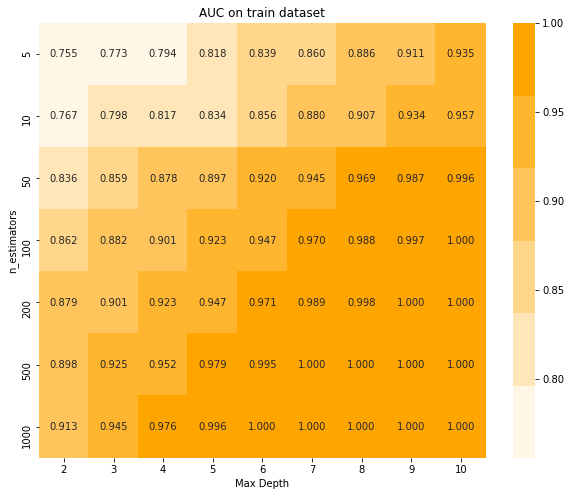

In [78]:
# Plotting plot of AUC for each combination of hyper parameters
xg_plot_train_auc_heatmap(train_auc)

In [79]:
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# In this section we will perform 3-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # Deecision Tree Classifier
        clf = XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1)
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(train_tfidf_avg_w2v):
            x_train = train_tfidf_avg_w2v[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = train_tfidf_avg_w2v[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|██████████| 7/7 [1:16:13<00:00, 1086.03s/it]


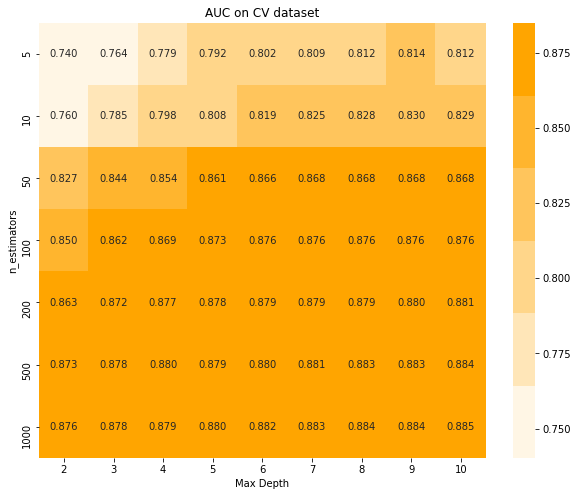

In [80]:
# Plotting plot of AUC for each combination of hyper parameters
xg_plot_test_auc_heatmap(cv_auc)

In [97]:
# Training the final model on best hyper-parameters
clf = XGBClassifier(n_estimators=1000,max_depth=5,n_jobs=-1)
clf.fit(train_tfidf_avg_w2v,Y_train)

predict_y_test = clf.predict(test_tfidf_avg_w2v)
predict_y_train = clf.predict(train_tfidf_avg_w2v)

probab_y_test = clf.predict_proba(test_tfidf_avg_w2v)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(train_tfidf_avg_w2v)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Avg Word2Vec Vectorized Model is {:.3f}".format(auc))

Auc of Avg Word2Vec Vectorized Model is 0.890


For test dataset


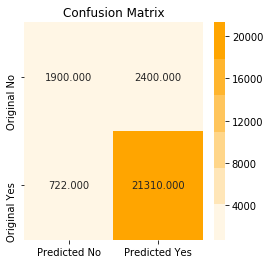

In [98]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


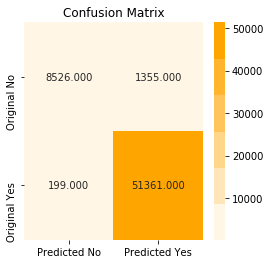

In [99]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

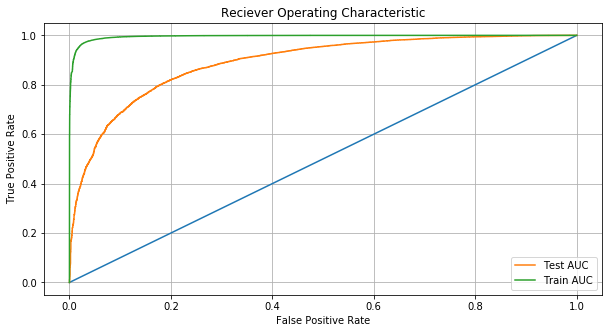

In [100]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h1>Feature Engineering</h1>

<h3>Using Review Length as feature<h3>

In [107]:
# Splitting summary into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,Y,test_size=0.3,random_state=42)

In [108]:
# For reviews train and test dataset
# Taking only 2000 features as training takes a lot of time
count_vect = CountVectorizer(max_features=2000)
# For train dataset
bow_train_vect = count_vect.fit_transform(X_train)
print(bow_train_vect.shape)

# For test dataset
bow_test_vect = count_vect.transform(X_test)
print(bow_test_vect.shape)

(61441, 2000)
(26332, 2000)


In [109]:
# Calculating and storing length of each review in train data set, in an numpy array

train_review_len = np.zeros(len(X_train))
i=0
for sent in X_train:
    train_review_len[i] = len(sent)
    i += 1

print(train_review_len.shape)

(61441,)


In [110]:
# Calculating and storing length of each review in train data set, in an numpy array

test_review_len = np.zeros(len(X_test))
i=0
for sent in X_test:
    test_review_len[i] = len(sent)
    i += 1

print(test_review_len.shape)

(26332,)


In [111]:
print(bow_train_vect.shape)
print(bow_test_vect.shape)

(61441, 2000)
(26332, 2000)


In [112]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

# now we will add review length as a new feature to train  data set
# The shape of train_review_len is 254919 and hstack takes compatible matrices only 
# Making the train_review_len to bow_train_vect
A = coo_matrix([train_review_len]).T

bow_train_vect = hstack([bow_train_vect,A])
print(bow_train_vect.shape)

(61441, 2001)


In [113]:
# now we will add review length as a new feature to train  data set
# Since hstack takes compatible matrices only 
# Making the test_review_len to bow_test_vect
B = coo_matrix([test_review_len]).T
bow_test_vect = hstack([bow_test_vect,B])
print(bow_test_vect.shape)

(26332, 2001)


In [114]:
from scipy import sparse
# Converting bow_train_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
print(type(bow_train_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [115]:
# Doing same as above for test dataset
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [116]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.transform(bow_test_vect)

In [117]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

<h2>Training Random Forest Model</h2>

In [118]:
# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        clf.fit(bow_train_vect,Y_train)
        
        predict_probab = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:58<00:00, 70.25s/it]


Training AUC


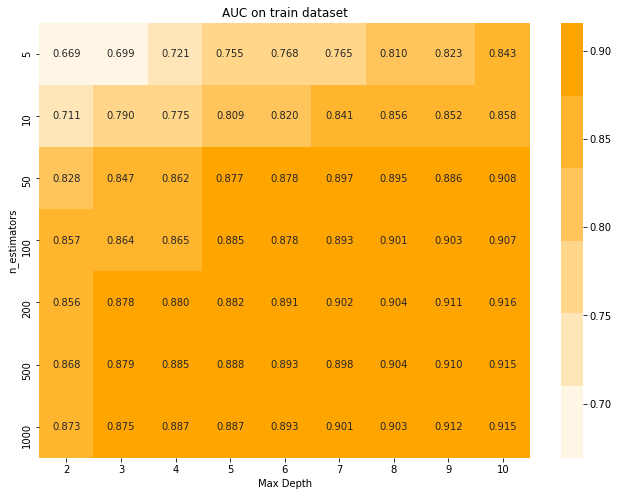

In [119]:
# Plotting plot of AUC for each combination of hyper parameters
print("Training AUC")
plot_train_auc_heatmap(train_auc)

In [120]:
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # Deecision Tree Classifier
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(bow_train_vect):
            x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [11:02<00:00, 151.07s/it]


Validation  AUC


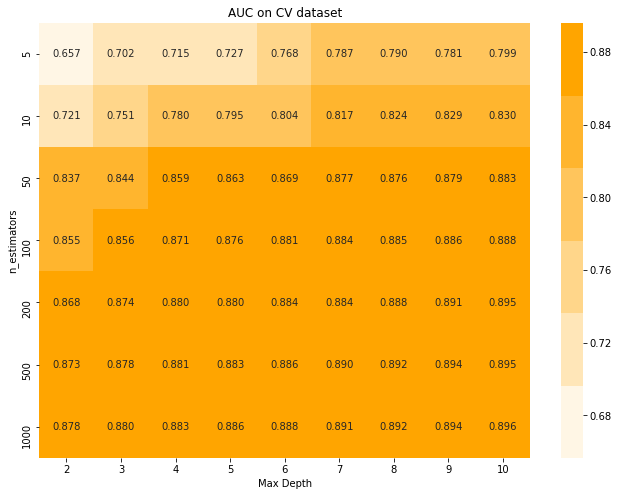

In [121]:
# Plotting plot of AUC for each combination of hyper parameters
print("Validation  AUC")
plot_test_auc_heatmap(cv_auc)

In [122]:
# Training the final model on best hyper-parameters
clf = RandomForestClassifier(n_estimators=1000,max_depth=10,n_jobs=-1,class_weight='balanced')
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)
predict_y_train = clf.predict(bow_train_vect)

probab_y_test = clf.predict_proba(bow_test_vect)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Bow Vectorized Model is {:.3f}".format(auc))

Auc of Bow Vectorized Model is 0.900


For test dataset


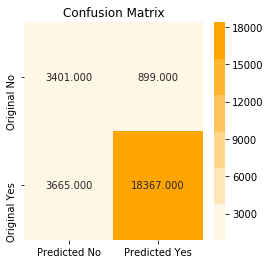

In [123]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


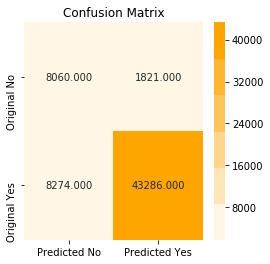

In [124]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

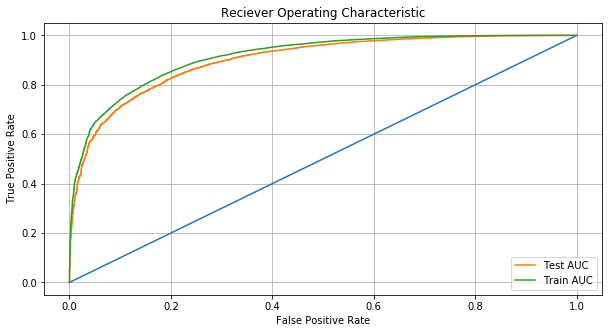

In [125]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h2>Training XGBClassifier</h2>

In [112]:
# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
from xgboost import XGBClassifier
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf = XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1)
        clf.fit(bow_train_vect,Y_train)
        
        predict_probab = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.

100%|██████████| 7/7 [11:52<00:00, 163.32s/it]


Training AUC


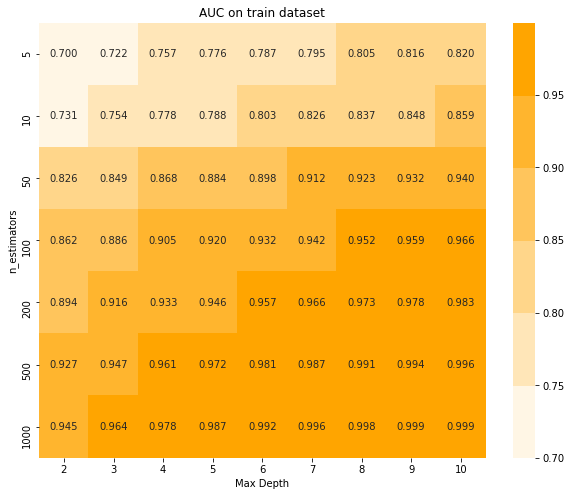

In [113]:
# Plotting plot of AUC for each combination of hyper parameters
print("Training AUC")
xg_plot_train_auc_heatmap(train_auc)

In [114]:
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # Deecision Tree Classifier
        clf = XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1)
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(bow_train_vect):
            x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|██████████| 7/7 [30:52<00:00, 427.82s/it]


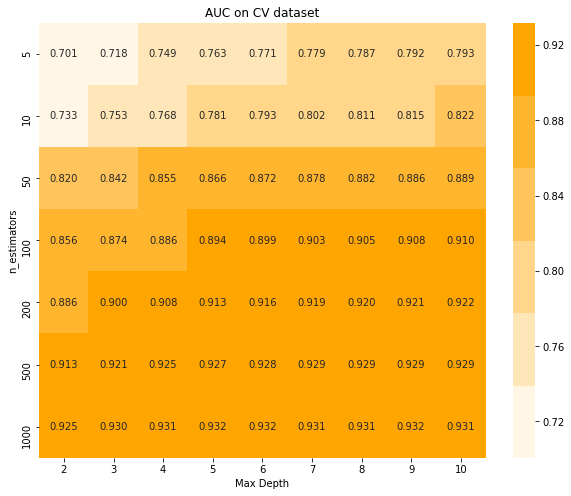

In [115]:
# Plotting plot of AUC for each combination of hyper parameters
xg_plot_test_auc_heatmap(cv_auc)

In [116]:
# Training the final model on best hyper-parameters
clf = XGBClassifier(n_estimators=1000,max_depth=5,n_jobs=-1)
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)
predict_y_train = clf.predict(bow_train_vect)

probab_y_test = clf.predict_proba(bow_test_vect)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Bow Vectorized Model is {:.3f}".format(auc))

Auc of Bow Vectorized Model is 0.943


For test dataset


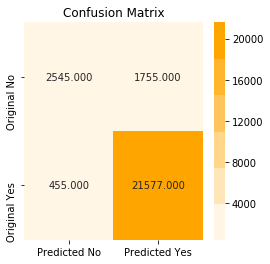

In [117]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


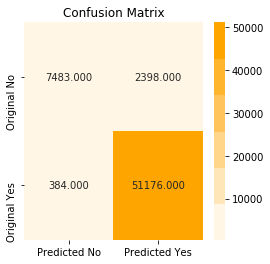

In [118]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

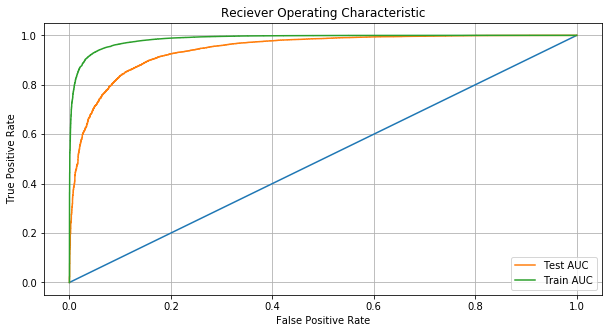

In [119]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h1>Using Review Summary As a feature</h1>

In [126]:
train_summ,test_summ,Y_train_summ,Y_test_summ = train_test_split(preprocessed_summary,Y,test_size=0.3,random_state=42)

In [127]:
# Using bag of words to vectorize summary
# For train dataset
count_vect = CountVectorizer(max_features=200)
# For train dataset
train_vect = count_vect.fit_transform(train_summ)
print(train_vect.shape)

# for test dataset
test_vect = count_vect.transform(test_summ)
print(test_vect.shape)

(61441, 200)
(26332, 200)


In [128]:
# now we will add vectorized review as a new feature to train  data set
bow_train_vect = hstack([bow_train_vect,train_vect])
print(bow_train_vect.shape)

(61441, 2201)


In [129]:
# now we will add vectorized review as a new feature to train  data set
bow_test_vect = hstack([bow_test_vect,test_vect])
print(bow_test_vect.shape)

(26332, 2201)


In [130]:
# Converting bow_train_vect and bow_test_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_train_vect))
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [131]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.transform(bow_test_vect)

<h2>Training Random Forest Model</h2>

In [132]:
# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        clf.fit(bow_train_vect,Y_train)
        
        predict_probab = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:19<00:00, 75.66s/it]


Training AUC


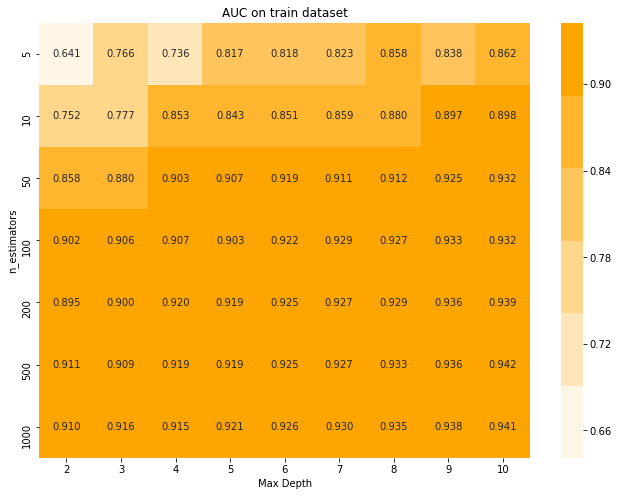

In [133]:
# Plotting plot of AUC for each combination of hyper parameters
print("Training AUC")
plot_train_auc_heatmap(train_auc)

In [134]:
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# In this section we will perform 3-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # Deecision Tree Classifier
        clf = RandomForestClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(bow_train_vect):
            x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:53<00:00, 93.48s/it]


Validation  AUC


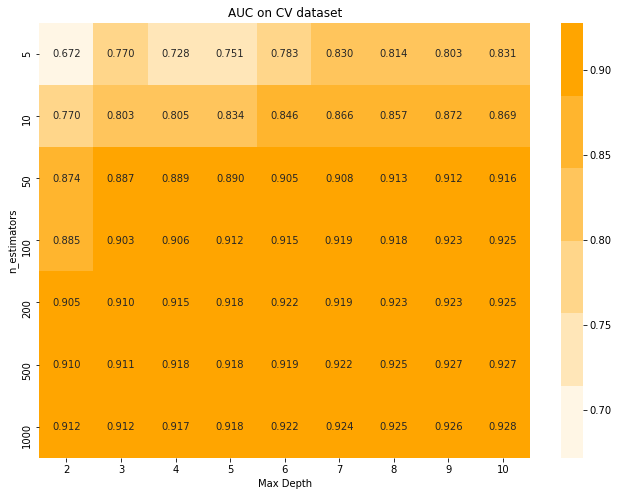

In [135]:
# Plotting plot of AUC for each combination of hyper parameters
print("Validation  AUC")
plot_test_auc_heatmap(cv_auc)

In [136]:
# Training the final model on best hyper-parameters
clf = RandomForestClassifier(n_estimators=1000,max_depth=10,n_jobs=-1,class_weight='balanced')
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)
predict_y_train = clf.predict(bow_train_vect)

probab_y_test = clf.predict_proba(bow_test_vect)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Bow Vectorized Model is {:.3f}".format(auc))

Auc of Bow Vectorized Model is 0.932


For test dataset


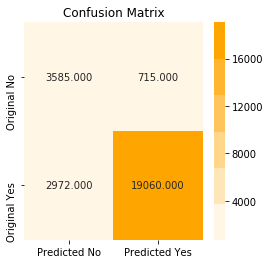

In [137]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


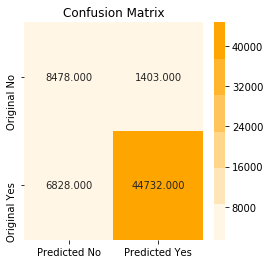

In [138]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

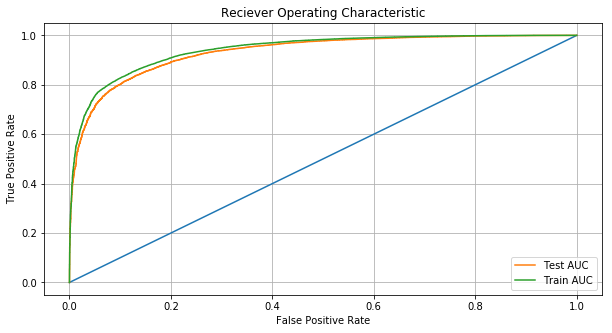

In [139]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Training XGBClassifier</h3>

In [143]:
# Trainig the model and testing on train data to find AUC on train data.
# This will store the AUC for each combination of depth and min sample.
# Here row corresponds to depth and columns corresponds to min sample.
from xgboost import XGBClassifier
train_auc = np.zeros(shape=(len(n_estimators),len(max_depth)))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of rows.
j=0 # To kepe count of columns.
for k in tqdm(n_estimators):
    j=0 # Reinitializing column to zero for each row
    for s in max_depth:
        clf = XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        clf.fit(bow_train_vect,Y_train)
        
        predict_probab = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc[i][j] = auc
        j  =j+1 # incrementing the col index at the end of each iteration.
    i = i+1 # incrementing row index at the end of each iteration.

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [24:30<00:00, 342.86s/it]


Training AUC


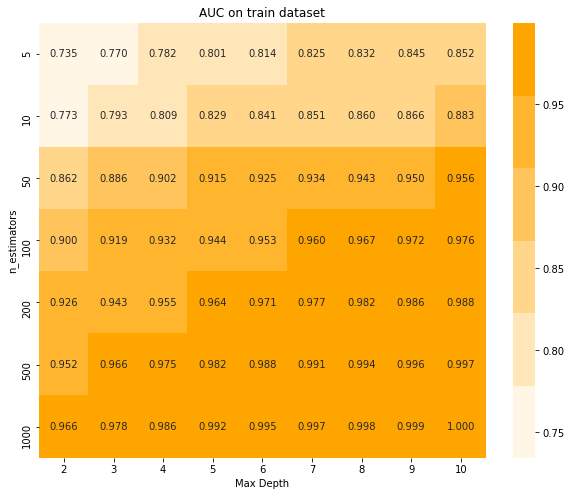

In [144]:
# Plotting plot of AUC for each combination of hyper parameters
print("Training AUC")
xg_plot_train_auc_heatmap(train_auc)

In [145]:
# Time series object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc = np.zeros(shape = (len(n_estimators),len(max_depth))) # will contain cross validation AUC corresponding to each k 
m=0 # For row index
n=0 # For col index
for k in tqdm(n_estimators):
    n=0
    for s in max_depth:
        # Deecision Tree Classifier
        clf = XGBClassifier(n_estimators=k,max_depth=s,n_jobs=-1,class_weight='balanced')
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(bow_train_vect):
            x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
        
        cv_auc[m][n] = auc/i # Storing AUC value
        n = n+1 # Incrementing col index after each iteration
    m = m+1 # Incrementing row index after each iteration

100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [1:00:29<00:00, 861.24s/it]


Validation  AUC


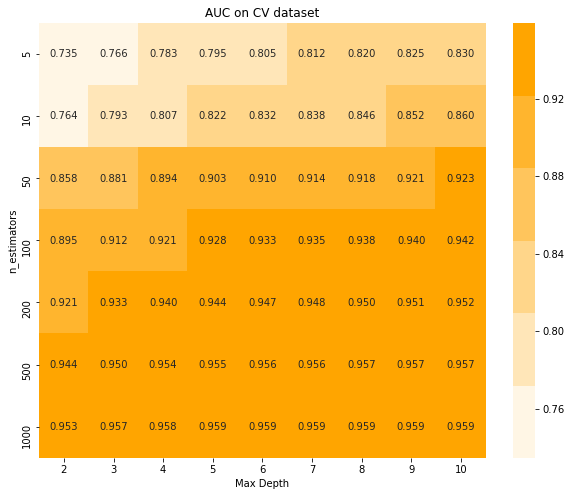

In [146]:
# Plotting plot of AUC for each combination of hyper parameters
print("Validation  AUC")
xg_plot_test_auc_heatmap(cv_auc)

In [147]:
# Training the final model on best hyper-parameters
clf = XGBClassifier(n_estimators=1000,max_depth=5,n_jobs=-1,class_weight='balanced')
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)
predict_y_train = clf.predict(bow_train_vect)

probab_y_test = clf.predict_proba(bow_test_vect)[:,1] # returns probability for positive class points.
probab_y_train = clf.predict_proba(bow_train_vect)[:,1] # returns probability for positive class points.
auc = roc_auc_score(Y_test,probab_y_test)

print("Auc of Bow Vectorized feature engineered Model is {:.3f}".format(auc))

Auc of Bow Vectorized feature engineered Model is 0.966


For test dataset


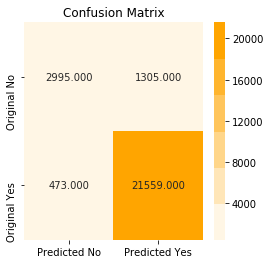

In [148]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset


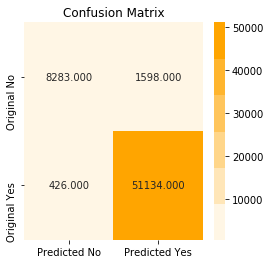

In [149]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

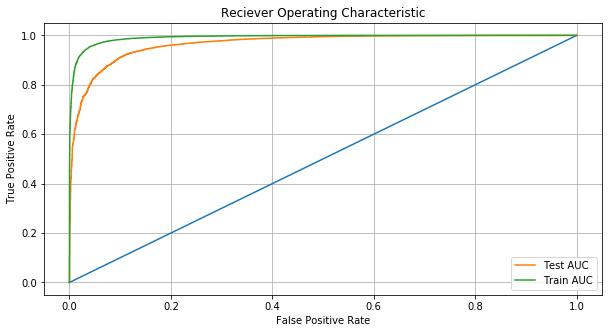

In [150]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

# [6] Conclusions

In [151]:
from prettytable import PrettyTable

# Initializing table object
print("For Random Forest")
x = PrettyTable()

x.field_names = ["Vectorizer","Model","n_estimators","Max Depth","Area Under Curve"]

x.add_row([ "Bow","Random Forest","1000","10","0.927" ])
x.add_row([ "Tfidf","Random Forest","1000","10","0.918" ])
x.add_row([ "AvgW2V","Random Forest","1000","10","0.903" ])
x.add_row([ "Tfidf weighted W2V","Random Forest","1000","10","0.874" ])
x.add_row([ "Bow with review length ","Random Forest","1000","10","0.900" ])
x.add_row([ "Bow with summary feature","Random Forest","1000","10","0.932" ])
print(x)

For Random Forest
+--------------------------+---------------+--------------+-----------+------------------+
|        Vectorizer        |     Model     | n_estimators | Max Depth | Area Under Curve |
+--------------------------+---------------+--------------+-----------+------------------+
|           Bow            | Random Forest |     1000     |     10    |      0.927       |
|          Tfidf           | Random Forest |     1000     |     10    |      0.918       |
|          AvgW2V          | Random Forest |     1000     |     10    |      0.903       |
|    Tfidf weighted W2V    | Random Forest |     1000     |     10    |      0.874       |
| Bow with review length   | Random Forest |     1000     |     10    |      0.900       |
| Bow with summary feature | Random Forest |     1000     |     10    |      0.932       |
+--------------------------+---------------+--------------+-----------+------------------+


In [152]:
# Initializing table object
print("For XGBoost")
x = PrettyTable()

x.field_names = ["Vectorizer","Model","n_estimators","Max Depth","Area Under Curve"]

x.add_row([ "Bow","XGBoost","1000","5","0.943" ])
x.add_row([ "Tfidf","XGBoost","1000","4","0.946" ])
x.add_row([ "AvgW2V","Random Forest","1000","3","0.913" ])
x.add_row([ "Tfidf weighted W2V","XGBoost","1000","5","0.890" ])
x.add_row([ "Bow with review length ","XGBoost","1000","5","0.943" ])
x.add_row([ "Bow with summary feature","XGBoost","1000","5","0.966" ])
print(x)

For XGBoost
+--------------------------+---------------+--------------+-----------+------------------+
|        Vectorizer        |     Model     | n_estimators | Max Depth | Area Under Curve |
+--------------------------+---------------+--------------+-----------+------------------+
|           Bow            |    XGBoost    |     1000     |     5     |      0.943       |
|          Tfidf           |    XGBoost    |     1000     |     4     |      0.946       |
|          AvgW2V          | Random Forest |     1000     |     3     |      0.913       |
|    Tfidf weighted W2V    |    XGBoost    |     1000     |     5     |      0.890       |
| Bow with review length   |    XGBoost    |     1000     |     5     |      0.943       |
| Bow with summary feature |    XGBoost    |     1000     |     5     |      0.966       |
+--------------------------+---------------+--------------+-----------+------------------+


<h1>Explaination</h1>
<h4>We first cleaned our data by removing tags and non alphanumeric and stopwords. Then we divided our dataset into train and test dataset.</h4>
<h4>To prevent data leakage we have trained word2vec model on train data and used the same for test. We have done same in case of tfidf weighted word2vec.</h4>
<h4>To print top 20 features we have used featur_importances method to get indexes of top20 features and printed them using wordcloud.</h4>
<h4>AUC of Random Forest model is descent. Using review length as a feature improved AUC of the Random Forest model.</h4>
<h4>Using bow features extracted from review summary improved AUC of the Random Forest Model from 0.927 to 0.932</h4>
<h4>XGBoost model had far better performance then Random Forest Models.</h4>
<h4>We have to create dataframe from Bow,Tfidf.Avg W2v and TfidfW2v as XGBoost Dont take matrices as input.</h4>
<h4>For all the models we can see that the train AUC and test AUC does not differ by a large value. Hence we can conclude that our model have not overfit.</h4>
<h4>Using Summary as a feature significantly improved the AUC of Bow Trained XGBoost model to 0.966</h4>
<h4>Overall the best model is XGBoost traained on Bow vectorized in which we are using Reviews , Review length and Summary as a feature.</h4>